The motivation for this notebook is to check whether the exact constraints of mass & enthalpy conservation always hold in every dataset that we would like to study, notably the base (fluxbypassaqua), and the two generalization datasets (+4K) and (+3Kw1). We will:  
1) Check the water budget in dimensional and dimensionless forms in the base dataset  
2) Move to (+4K) to see if it still holds

# 1) Load constants, network configuration, etc

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 2) +0K Validation dataset

In [2]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-02-02-00000.nc', 
                     decode_times=False)
ds0 = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-02-01-00000.nc', 
                     decode_times=False)

In [5]:
dir(ds.P0)

['T',
 '_DataArray__default',
 '_DataArray__default_name',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 

In [5]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [9]:
# tgb - 6/26/2019 - Import the +4K dataset here just to compare surface temperatures
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/'
ds4K = xr.open_dataset(DATADIR + 'sp8fbp_4k.cam2.h2.0000-01-01-00000.nc', 
                     decode_times=False)

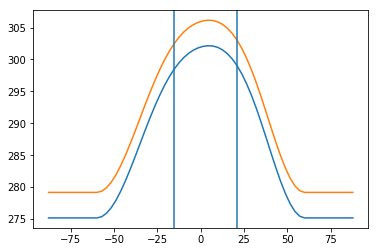

In [20]:
import matplotlib.pyplot as plt
plt.plot(coor.lat,ds.TS.mean(dim=['lon','time']))
plt.plot(coor.lat,ds4K.TS.mean(dim=['lon','time']))

# Find latitude range for which SST(+4K)>max(SST(+0K))
Tsmax = np.max(ds.TS.values)
lat_warm = coor.lat[ds4K.TS.mean(dim=['lon','time']).values>Tsmax]
plt.axvline(x=np.min(lat_warm))
plt.axvline(x=np.max(lat_warm))

In [29]:
print(np.amin(np.abs(coor.lat)))
print(np.argmin(np.abs(coor.lat)))
print(coor.lat[31:33])

<xarray.DataArray 'lat' ()>
array(1.395307)
<xarray.DataArray 'lat' ()>
array(31)
<xarray.DataArray 'lat' (lat: 2)>
array([-1.395307,  1.395307])
Coordinates:
  * lat      (lat) float64 -1.395 1.395
Attributes:
    long_name:  latitude
    units:      degrees_north


In [19]:
lat_warm.values

array([-15.34836476, -12.55775612,  -9.76714556,  -6.97653355,
        -4.18592053,  -1.39530691,   1.39530691,   4.18592053,
         6.97653355,   9.76714556,  12.55775612,  15.34836476,
        18.13897099,  20.92957425])

## Local conservation

In [202]:
# Pick a point
it = 5
ilon = 23
ilat = 35
# Calculate residual
# 0) Pressure coordinate
P = np.expand_dims(ds.P0,axis=0)*hyai+\
np.expand_dims(ds.PS[it,ilon,ilat],axis=0)*hybi;
dP = P[1:]-P[:-1]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*\
                (ds.PHCLDICE[it,:,ilon,ilat]+\
                 ds.PHCLDLIQ[it,:,ilon,ilat]+\
                 ds.PHQ[it,:,ilon,ilat]),axis=0);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[it,ilon,ilat]+\
                  1e-3*ds.PRECTEND[it,ilon,ilat]);
# 3) Latent heat flux
LHF = ds.LHFLX[it-1,ilon,ilat];
# 3) Residual of water budget
RES = -WATINT-PREC+LHF;
print('WATINT',WATINT.values)
print('PREC',PREC.values)
print('LHF',LHF.values)
print('RES',RES.values)

WATINT 79.41151849249485
PREC 0.3312984943448783
LHF 79.7429
RES 8.00468516786168e-05


In [203]:
RES

<xarray.DataArray ()>
array(8.004685e-05)
Coordinates:
    lat      float64 -23.72
    lon      float64 98.44

## Global conservation

In [204]:
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[:-1,:,:]; 

WATINT -4.8313900769658815
PREC 82.226135
LHF 77.39475
RESIDUAL -2.921435914140063e-07


Text(0.5, 0, 'Residual (W/m2)')

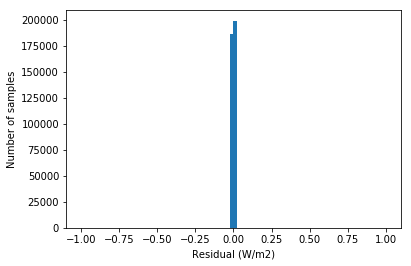

In [205]:
print('WATINT',WATINT.values.mean(axis=(0,1,2)))
print('PREC',PREC.values.mean(axis=(0,1,2)))
print('LHF',ds.LHFLX.values[:-1,:,:].mean(axis=(0,1,2)))
print('RESIDUAL',RES.values.mean(axis=(0,1,2)))
plt.hist(RES.values.flatten(), bins=100, range=(-1,1))
plt.ylabel('Number of samples')
plt.xlabel('Residual (W/m2)')

tgb - 6/25/2019 - Got the date range function from https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python

In [179]:
from datetime import timedelta, date
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [185]:
start_date = date(1, 1, 1)
end_date = date(1, 5, 1)
for single_date in daterange(start_date, end_date):
    print(single_date.strftime("%Y-%m-%d"))

1-01-01
1-01-02
1-01-03
1-01-04
1-01-05
1-01-06
1-01-07
1-01-08
1-01-09
1-01-10
1-01-11
1-01-12
1-01-13
1-01-14
1-01-15
1-01-16
1-01-17
1-01-18
1-01-19
1-01-20
1-01-21
1-01-22
1-01-23
1-01-24
1-01-25
1-01-26
1-01-27
1-01-28
1-01-29
1-01-30
1-01-31
1-02-01
1-02-02
1-02-03
1-02-04
1-02-05
1-02-06
1-02-07
1-02-08
1-02-09
1-02-10
1-02-11
1-02-12
1-02-13
1-02-14
1-02-15
1-02-16
1-02-17
1-02-18
1-02-19
1-02-20
1-02-21
1-02-22
1-02-23
1-02-24
1-02-25
1-02-26
1-02-27
1-02-28
1-03-01
1-03-02
1-03-03
1-03-04
1-03-05
1-03-06
1-03-07
1-03-08
1-03-09
1-03-10
1-03-11
1-03-12
1-03-13
1-03-14
1-03-15
1-03-16
1-03-17
1-03-18
1-03-19
1-03-20
1-03-21
1-03-22
1-03-23
1-03-24
1-03-25
1-03-26
1-03-27
1-03-28
1-03-29
1-03-30
1-03-31
1-04-01
1-04-02
1-04-03
1-04-04
1-04-05
1-04-06
1-04-07
1-04-08
1-04-09
1-04-10
1-04-11
1-04-12
1-04-13
1-04-14
1-04-15
1-04-16
1-04-17
1-04-18
1-04-19
1-04-20
1-04-21
1-04-22
1-04-23
1-04-24
1-04-25
1-04-26
1-04-27
1-04-28
1-04-29
1-04-30


In [186]:
dir(single_date)

['__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 'ctime',
 'day',
 'fromordinal',
 'fromtimestamp',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'min',
 'month',
 'replace',
 'resolution',
 'strftime',
 'timetuple',
 'today',
 'toordinal',
 'weekday',
 'year']

In [ ]:
# Loop over days of the year
start_date = date(0, 1, 1)
end_date = date(0, 3, 1)
for single_date in daterange(start_date, end_date):
    print single_date.strftime("%Y-%m-%d")
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[:-1,:,:]; 

# 3) +4K dataset

In [190]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'sp8fbp_4k.cam2.h2.0000-01-01-00000.nc', 
                     decode_times=False)
ds0 = xr.open_dataset(DATADIR + 'sp8fbp_4k.cam2.h2.0000-02-03-00000.nc', 
                     decode_times=False)

In [191]:
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[1:,:,:]; 

WATINT 48.110187875568684
PREC 112.25614
LHF 160.36557
RESIDUAL -0.000739999625512002


Text(0.5, 0, 'Residual (W/m2)')

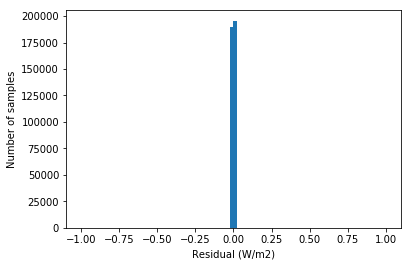

In [193]:
print('WATINT',WATINT.values.mean(axis=(0,1,2)))
print('PREC',PREC.values.mean(axis=(0,1,2)))
print('LHF',ds.LHFLX.values[1:,:,:].mean(axis=(0,1,2)))
print('RESIDUAL',RES.values.mean(axis=(0,1,2)))
plt.hist(RES.values.flatten(), bins=100, range=(-1,1))
plt.ylabel('Number of samples')
plt.xlabel('Residual (W/m2)')

# 4) +3Kw1 dataset

In [198]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_3kw1/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'sp8fbp_3kw1.cam2.h2.0001-04-03-00000.nc', 
                     decode_times=False)
ds0 = xr.open_dataset(DATADIR + 'sp8fbp_3kw1.cam2.h2.0001-04-02-00000.nc', 
                     decode_times=False)

In [199]:
# 0) Pressure coordinate
P = np.moveaxis(np.tile(np.expand_dims(ds.P0,axis=0)*hyai,\
                        (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
                3,1)+\
np.moveaxis(np.tile(ds.PS[1:,:,:],(hybi.shape[0],1,1,1)),0,1)*\
np.moveaxis(np.tile(hybi,\
                    (ds.PS.shape[0]-1,ds.PS.shape[1],ds.PS.shape[2],1)),\
            3,1)
dP = P[:,1:,:,:]-P[:,:-1,:,:]
# 1) Water integral
WATINT = np.sum(L_V/G*dP*(ds.PHCLDICE[1:,:,:,:]+\
                          ds.PHCLDLIQ[1:,:,:,:]+\
                          ds.PHQ[1:,:,:,:]),axis=1);
# 2) Precipitation
PREC = RHO_L*L_V*(ds.PRECT[1:,:,:]+1e-3*ds.PRECTEND[1:,:,:]);
# 3) Residual of water budget
RES = -WATINT-PREC+ds.LHFLX.values[1:,:,:]; 

WATINT -1.055444878138102
PREC 74.544716
LHF 73.510574
RESIDUAL 2.0293437252563095e-06


Text(0.5, 0, 'Residual (W/m2)')

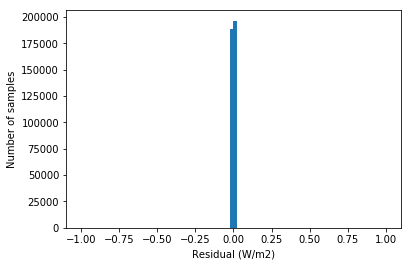

In [200]:
print('WATINT',WATINT.values.mean(axis=(0,1,2)))
print('PREC',PREC.values.mean(axis=(0,1,2)))
print('LHF',ds.LHFLX.values[:-1,:,:].mean(axis=(0,1,2)))
print('RESIDUAL',RES.values.mean(axis=(0,1,2)))
plt.hist(RES.values.flatten(), bins=100, range=(-1,1))
plt.ylabel('Number of samples')
plt.xlabel('Residual (W/m2)')